In [1]:
#Code by David Roberts https://www.kaggle.com/code/davidbroberts/tensorflow-transfer-learning/notebook

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # Set the log level to keep the warnings down
import torch
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from lib.datasets.datasets import BinMaze
from tqdm import tqdm
from lib.datasets.datasets import get_maze_data
from torch.utils.data import Dataset, DataLoader
import torchvision
from config.config_tauUnet_maze import get_config
from lib.datasets.maze import maze_gen
import torchvision.transforms as transforms 
import matplotlib.pyplot as plt
import lib.utils.bookkeeping as bookkeeping
from pathlib import Path
import lib.models.models as models
import lib.models.model_utils as model_utils
import lib.datasets.datasets as datasets
import lib.datasets.dataset_utils as dataset_utils
import lib.losses.losses as losses
import lib.losses.losses_utils as losses_utils
import lib.training.training as training
import lib.training.training_utils as training_utils
import lib.optimizers.optimizers as optimizers
import lib.optimizers.optimizers_utils as optimizers_utils
import lib.loggers.loggers as loggers
import lib.loggers.logger_utils as logger_utils


In [2]:
"""
save_location = '/Users/paulheller/PythonRepositories/Master-Thesis/ContTimeDiscreteSpace/TAUnSDDM/SavedModels/'
experiment_name = 'MAZE'
cfg = get_config()
save_dir, checkpoint_dir, config_dir = \
                bookkeeping.create_experiment_folder(
                    cfg.save_location,
                    cfg.experiment_name,
                    False
            )
bookkeeping.save_config_as_yaml(cfg, config_dir)
bookkeeping.save_git_hash(save_dir)
print(save_dir)
model = model_utils.create_model(cfg, device='cpu')
print("number of parameters: ", sum([p.numel() for p in model.parameters()]))
optimizer = optimizers_utils.get_optimizer(model.parameters(), cfg)
state = {
        'model': model,
        'optimizer': optimizer,
        'n_iter': 0
    }
bookkeeping.setup_preemption(
            save_dir, checkpoint_dir, state,
            2,
            True
        )
preempted_path = Path("null")
preemption_start_day_YYYYhyphenMMhyphenDD = '2023-10-31'
preempted_path = bookkeeping.check_for_preempted_run(
    cfg.save_location,
    preemption_start_day_YYYYhyphenMMhyphenDD,
    cfg,
    True
)
print(preempted_path.as_posix())
"""

SavedModels/MNIST/2023-11-06/mnist
number of parameters:  1427552
Bookkeeping: checking for preempted run
Bookkeeping: no preempted run found
null


In [4]:
import numpy as np
from lib.datasets.datasets import SudokuDataset
from config.config_tauScoreNet_sudoku import get_config
from lib.datasets import dataset_utils
from torch.utils.data import Dataset, DataLoader
cfg = get_config()
device = cfg.device 
dataset = dataset_utils.get_dataset(cfg, device)
def worker_init_fn(worker_id):
    np.random.seed(worker_id)
batch_size = 32
train_dataloader = DataLoader(dataset,
                                cfg.data.batch_size, shuffle=cfg.data.shuffle,
                                num_workers=4)
                                #worker_init_fn=worker_init_fn)


In [10]:
for i in train_dataloader:
    #print(i, type(i), i.shape)
    sample = i
    sample = sample.detach().cpu().numpy()
    correct = 0
    total = sample.shape[0]
    print(total)
    ans = sample.argmax(-1) + 1
    print(ans, ans.shape)
    numbers_1_N = np.arange(1, 9 + 1)
    print(numbers_1_N)
    corrects = []
    for board in ans:
        if np.all(np.sort(board, axis=1) == numbers_1_N) and np.all(
            np.sort(board.T, axis=1) == numbers_1_N
        ):
            # Check blocks

            blocks = board.reshape(3, 3, 3, 3).transpose(0, 2, 1, 3).reshape(9, 9)
            print(blocks, blocks.shape)
            if np.all(np.sort(board.T, axis=1) == numbers_1_N):
                correct += 1
                corrects.append(True)
            else:
                corrects.append(False)
        else:
            corrects.append(False)


        print("correct {} %".format(100 * correct / total))
    break

32
[[[2 4 3 ... 6 4 5]]

 [[2 6 1 ... 1 5 2]]

 [[4 6 2 ... 8 2 4]]

 ...

 [[5 8 3 ... 8 6 3]]

 [[7 5 2 ... 8 4 1]]

 [[7 2 8 ... 5 8 1]]] (32, 1, 81)
[1 2 3 4 5 6 7 8 9]
correct 0.0 %
correct 0.0 %
correct 0.0 %
correct 0.0 %
correct 0.0 %
correct 0.0 %
correct 0.0 %
correct 0.0 %
correct 0.0 %
correct 0.0 %
correct 0.0 %
correct 0.0 %
correct 0.0 %
correct 0.0 %
correct 0.0 %
correct 0.0 %
correct 0.0 %
correct 0.0 %
correct 0.0 %
correct 0.0 %
correct 0.0 %
correct 0.0 %
correct 0.0 %
correct 0.0 %
correct 0.0 %
correct 0.0 %
correct 0.0 %
correct 0.0 %
correct 0.0 %
correct 0.0 %
correct 0.0 %
correct 0.0 %


/var/folders/87/vb_q88mx6qxcy8jkjjpm9ns40000gn/T/ipykernel_55298/1318465308.py:14: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if np.all(np.sort(board, axis=1) == numbers_1_N) and np.all(


In [18]:
# Eine Funktion, um einige Bilder zu plotten
def show_images(images, n=8):
    plt.figure(figsize=(15, 15))
    for i in range(n):
        ax = plt.subplot(1, n, i + 1)
        plt.imshow(images[i].permute(1, 2, 0).numpy().astype("uint8"), cmap='gray')
        plt.axis("off")
    plt.show()
config = get_config()
img = maze_gen(limit=10, crop=True, size=30, dim_x=7, dim_y=7, pixelSizeOfTile=2, weightHigh=97,weightLow=97)
torch_dataloader = get_maze_data(config, img)


In [19]:
for i in tqdm(torch_dataloader):
    print(i.shape)
    break

  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([10, 1, 28, 28])


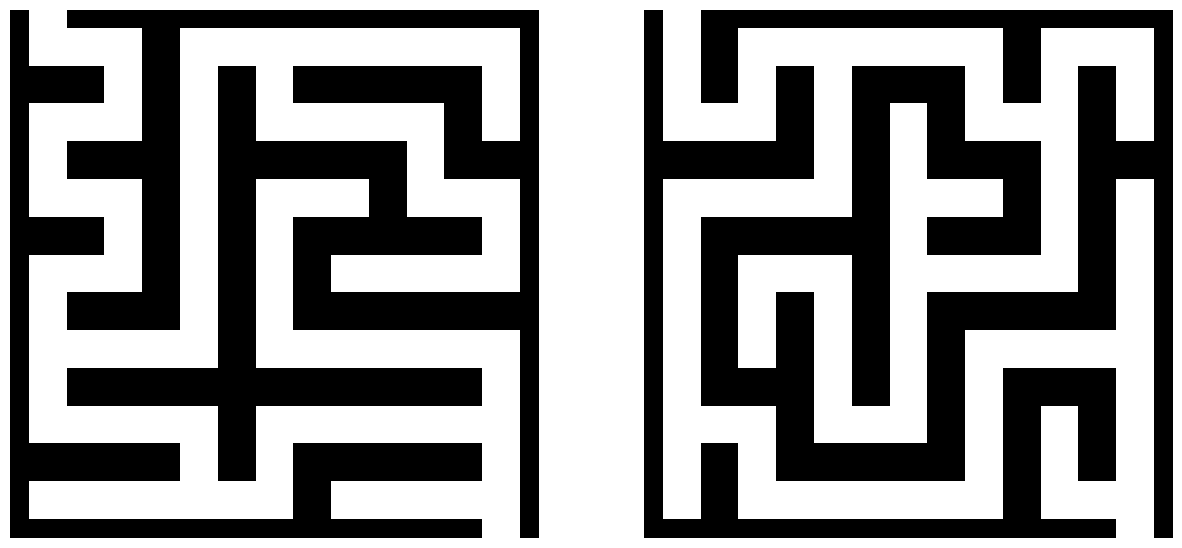

In [20]:
images = next(iter(torch_dataloader))
show_images(images[:4] * 255, n=2)